## This notebook shows an example where a set of electrodes are selected from a dataset and then LFP is extracted from those electrodes and then written to a new NWB file


### We assume that you have added an nwb file to the database (see Populate_from_NWB_tutorial notebook)

#### Load all of the relevant modules and set the environment variables. 
Note that the datadir and datadir/analysis must exist

In [1]:
%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
%load_ext autoreload
%autoreload 2


import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj

# the commands below can be run once to update your global configuration

#dj.config["enable_python_native_blobs"] = True
#dj.config["database.user"] = 'root'
#dj.config["database.password"] = 'tutorial'
#dj.config.save_global()

import nwb_datajoint as nd
import ndx_franklab_novela.probe

# Note that all of the following must exist
data_dir = '/Users/loren/data/nwb_builder_test_data'
os.environ['NWB_DATAJOINT_BASE_DIR'] = data_dir
os.environ['KACHERY_STORAGE_DIR'] = os.path.join(data_dir, 'kachery-storage')
os.environ['SPIKE_SORTING_STORAGE_DIR'] = os.path.join(data_dir, 'spikesorting')




env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
Connecting root@localhost:3306


#### Next we select the NWB file, which corresponds to the dataset we want to extract LFP from

In [2]:
import warnings
warnings.simplefilter('ignore')

/Users/loren/opt/anaconda3/envs/nwb_datajoint/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
nwb_file_names = nd.common.Nwbfile().fetch('nwb_file_name')
# take the first one for this demonstration
nwb_file_name = nwb_file_names[0]
print(nwb_file_name)

beans20190718.nwb


#### Create the standard LFP Filters. This only needs to be done once.

In [5]:
nd.common.FirFilter().create_standard_filters()

### Select every 16th electrode for LFP

In [6]:
electrode_ids = nd.common.Electrode.fetch('electrode_id')
lfp_electrode_ids = electrode_ids[range(0, len(electrode_ids), 16)]
nd.common.LFPSelection().set_lfp_electrodes(nwb_file_name, lfp_electrode_ids.tolist())


About to delete:
Nothing to delete


Show the list of selected electrodes. Note that the electrode_group corresponds to the physical probe the electrode was part of

In [7]:
nd.common.LFPSelection().LFPElectrode()

nwb_file_name the name of the NWB file,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode
beans20190718.nwb,0,0
beans20190718.nwb,0,21
beans20190718.nwb,0,43
beans20190718.nwb,0,64
beans20190718.nwb,0,85
beans20190718.nwb,0,107
beans20190718.nwb,1,128
beans20190718.nwb,1,149
beans20190718.nwb,1,171
beans20190718.nwb,1,192


### Or select one electrode for LFP


In [6]:
nd.common.LFPSelection().set_lfp_electrodes(nwb_file_name, [2])

About to delete:
Nothing to delete


### Populate the LFP table. Note that this takes 2 hours or so on a laptop if you use all electrodes and the full 75 GB beans data file

In [10]:
nd.common.LFP().populate()

writing new NWB file beans20190718_00000007.nwb
Output array should have shape (1091950, 12) and dtype <f8
Output array should have shape (212812, 12) and dtype <f8
Output array should have shape (2557744, 12) and dtype <f8
Output array should have shape (1356939, 12) and dtype <f8
Output array should have shape (1680945, 12) and dtype <f8
Checking output array shape is disabled, make sure portion of output array has shape (1091950, 12)
Checking output array shape is disabled, make sure portion of output array has shape (212812, 12)
Checking output array shape is disabled, make sure portion of output array has shape (2557744, 12)
Checking output array shape is disabled, make sure portion of output array has shape (1356939, 12)
Checking output array shape is disabled, make sure portion of output array has shape (1680945, 12)


### Now that we've created the LFP object we can perform a second level of filtering for a band of interest, in this case the theta band
We first need to create the filter

In [11]:
lfp_sampling_rate = (nd.common.LFP() & {'nwb_file_name' : nwb_file_name}).fetch1('lfp_sampling_rate')
filter_name = 'Theta 5-11 Hz'
nd.common.FirFilter().add_filter(filter_name, lfp_sampling_rate, 'bandpass', [4, 5, 11, 12], 'theta filter for 1 Khz data')

In [12]:
nd.common.FirFilter()

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest frequency for stop band for low frequency side of filter,filter_low_pass lowest frequency for pass band of low frequency side of filter,filter_high_pass highest frequency for pass band for high frequency side of filter,filter_high_stop highest frequency for stop band of high frequency side of filter,filter_comments comments about the filter,filter_band_edges numpy array containing the filter bands (redundant with individual parameters),filter_coeff numpy array containing the filter coefficients
LFP 0-400 Hz,20000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=
LFP 0-400 Hz,30000,lowpass,0.0,0.0,400.0,425.0,standard LFP filter for 20 KHz data,=BLOB=,=BLOB=
Theta 5-11 Hz,1000,lowpass,4.0,5.0,11.0,12.0,theta filter for 1 Khz data,=BLOB=,=BLOB=


Next we add an entry for the LFP Band and the electrodes we want to filter

In [13]:
# assume that we've filtered these electrodes; change this if not
lfp_band_electrode_ids = [0, 21, 43]

# set the interval list name corresponding to the second epoch (a run session)
interval_list_name = '02_r1'

# set the reference to -1 to indicate no reference for all channels
ref_elect = [-1]

# desired sampling rate
lfp_band_sampling_rate = lfp_sampling_rate // 10

In [14]:
nd.common.LFPBandSelection().set_lfp_band_electrodes(nwb_file_name, lfp_band_electrode_ids, filter_name, interval_list_name, ref_elect, lfp_band_sampling_rate)

Check to make sure it worked

In [15]:
nd.common.LFPBandSelection()

nwb_file_name the name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band
beans20190718.nwb,Theta 5-11 Hz,1000,02_r1,100


In [16]:
nd.common.LFPBandSelection().LFPBandElectrode()

nwb_file_name the name of the NWB file,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,reference_elect_id the reference electrode to use; -1 for no reference
beans20190718.nwb,Theta 5-11 Hz,1000,0,0,-1
beans20190718.nwb,Theta 5-11 Hz,1000,0,21,-1
beans20190718.nwb,Theta 5-11 Hz,1000,0,43,-1


In [26]:
nd.common.LFPBand().delete()

About to delete:
`common_ephys`.`__l_f_p_band`: 1 items


Proceed? [yes, No]:  yes


Committed.


In [25]:
nd.common.LFPBand().populate()

### Now we can plot the original signal, the LFP filtered trace, and the theta filtered trace together.
Much of the code below could be replaced by a function calls that would return the data from each electrical series, or better yet, plot the data in an electrical series.

In [18]:
import matplotlib.pyplot as plt
import numpy as np

In [19]:
#get the three electrical series objects and the indeces of the electrodes we band pass filtered
orig_eseries = (nd.common.Raw() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['raw']
orig_elect_indeces = nd.common.get_electrode_indeces(orig_eseries, lfp_band_electrode_ids)

lfp_eseries = (nd.common.LFP() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['lfp']
lfp_elect_indeces = nd.common.get_electrode_indeces(lfp_eseries, lfp_band_electrode_ids)

lfp_band_eseries = (nd.common.LFPBand() & {'nwb_file_name' : nwb_file_name}).fetch_nwb()[0]['filtered_data']
lfp_band_elect_indeces = nd.common.get_electrode_indeces(lfp_band_eseries, lfp_band_electrode_ids)


In [21]:
# get a list of times for the first run epoch and then select a 1 second interval 100 seconds from the beginning
run1times = (nd.common.IntervalList & {'interval_list_name' : '02_r1'}).fetch1('valid_times')
plottimes = [run1times[0][0] + 101, run1times[0][0] + 102]

In [22]:
# get the time indeces for each dataset
orig_time_ind = np.argwhere(np.logical_and(orig_eseries.timestamps > plottimes[0], orig_eseries.timestamps < plottimes[1]))
lfp_time_ind = np.argwhere(np.logical_and(lfp_eseries.timestamps > plottimes[0], lfp_eseries.timestamps < plottimes[1]))
lfp_band_time_ind = np.argwhere(np.logical_and(lfp_band_eseries.timestamps > plottimes[0], lfp_band_eseries.timestamps < plottimes[1]))

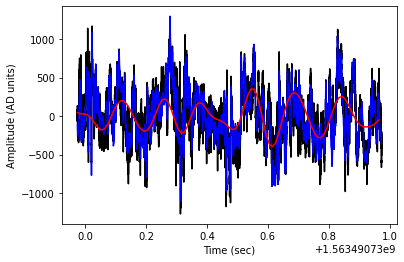

In [24]:
plt.plot(orig_eseries.timestamps[orig_time_ind], orig_eseries.data[orig_time_ind,orig_elect_indeces[1]], 'k-')
plt.plot(lfp_eseries.timestamps[lfp_time_ind], lfp_eseries.data[lfp_time_ind,lfp_elect_indeces[1]], 'b-')
plt.plot(lfp_band_eseries.timestamps[lfp_band_time_ind], lfp_band_eseries.data[lfp_band_time_ind,lfp_band_elect_indeces[1]], 'r-')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude (AD units)')

plt.show()